<a href="https://colab.research.google.com/github/ArcticFoox/optimization/blob/main/SGD_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Lec_NADL] 05/18

#수치 최적화 알고리즘
- GD: 경사 하강 (Gradient Descent)
- **Stochastic GD (SGD): 확률적 경사 하강**
- Adam: Adaptive Moments (Hybrid: Momentum 방법 & RMSProp 방법)

## **확률적 경사 하강 (SGD)**
- GD 대비 주요한 차이점
  - **탐색방향 결정(계산) 방법**

- 주요 용어
  - **배치**(batch) / **배치 크기**(batch size)
  - **epoch**(시대,에포크) (vs. iteration(반복))

* epoch:  learning 알고리즘에서'모든 training dataset'이 1회 사용되는 과정(단위)을 의미함.

### GD(선형회귀문제): 손실함수 & 탐색방향(손실함수의 gradient)


---
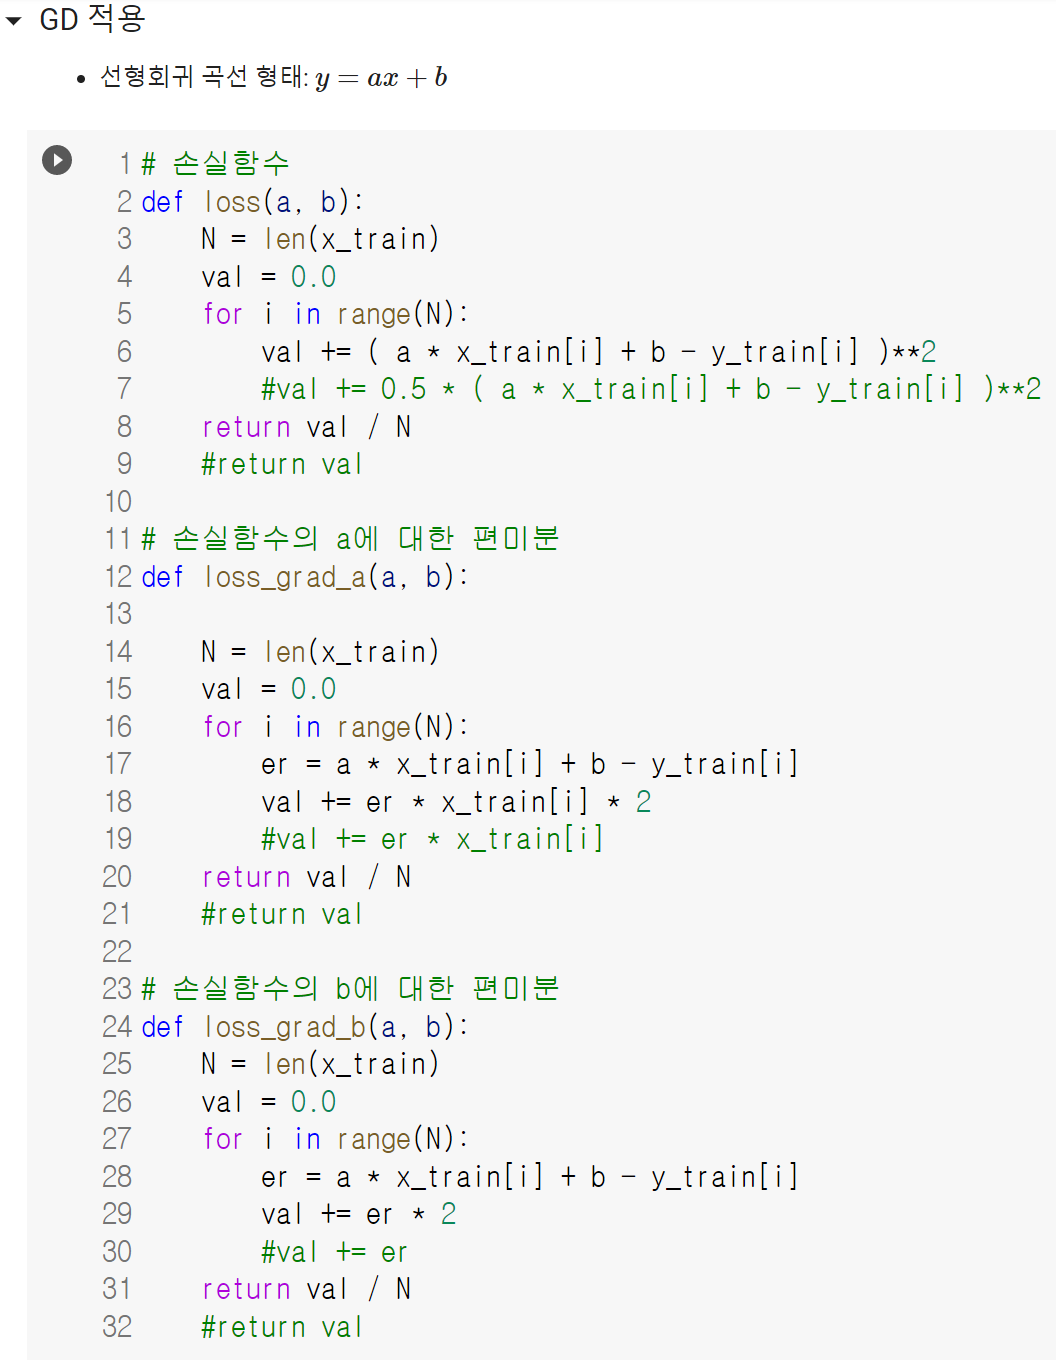



# 알고리즘 비교: **GD vs SGD**
- **GD: iteration**
  - 탐색방향 계산에 사용되는 자료?

- **SGD: epoch, batch(minibatch) 크기**
  - 각 배치에서 '탐색방향 계산에 사용되는 자료'?

- Deep Learning 활용 예: image classification
  - data: images
  - CIFAR10 [웹자료](https://www.cs.toronto.edu/~kriz/cifar.html)
    - 60,000 images (6,000 per class; 10 classes)
  - TensorFlow (시각화된 자료) [웹자료](https://www.tensorflow.org/datasets/catalog/cifar10)
  - PyTorch [웹자료](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

## **비교: GD vs SGD**

---
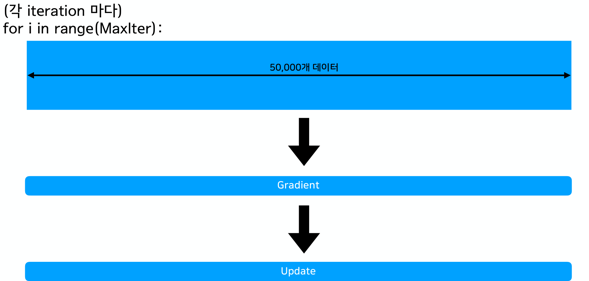




---

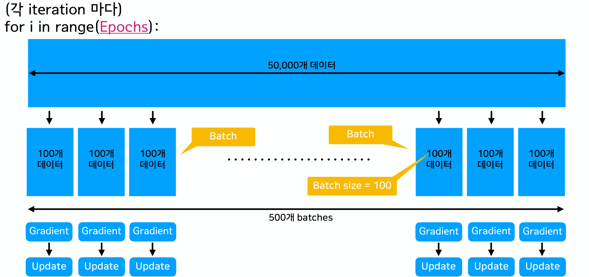



# **SGD: Part-A**

### Part: 자료(training data) 생성

[-1.         -0.95918367 -0.91836735 -0.87755102 -0.83673469 -0.79591837
 -0.75510204 -0.71428571 -0.67346939 -0.63265306 -0.59183673 -0.55102041
 -0.51020408 -0.46938776 -0.42857143 -0.3877551  -0.34693878 -0.30612245
 -0.26530612 -0.2244898  -0.18367347 -0.14285714 -0.10204082 -0.06122449
 -0.02040816  0.02040816  0.06122449  0.10204082  0.14285714  0.18367347
  0.2244898   0.26530612  0.30612245  0.34693878  0.3877551   0.42857143
  0.46938776  0.51020408  0.55102041  0.59183673  0.63265306  0.67346939
  0.71428571  0.75510204  0.79591837  0.83673469  0.87755102  0.91836735
  0.95918367  1.        ]

[0.78574159 0.62279481 0.93814004 0.72150122 0.86499739 0.85115953
 0.63109945 0.67370079 0.90634104 0.7042696  0.75735387 1.09007932
 0.94743363 0.92818283 1.06045081 0.99368385 1.06051158 1.21971149
 1.08782982 1.04038442 1.23899142 1.14773768 1.31747766 1.32483893
 1.34687377 1.37697682 1.1934449  1.13853236 1.2355545  1.22705389
 1.25411949 1.1516581  1.51647387 1.38753167 1.5511003

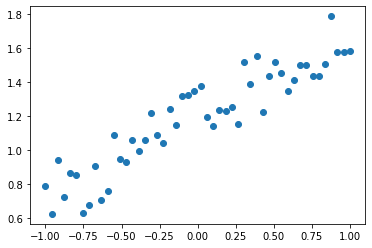

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(320)

x_train = np.linspace(-1, 1, 50)
f = lambda x: 0.5 * x + 1.0

idx_scat = 0.4
y_train = f(x_train) + idx_scat * np.random.rand(len(x_train))
print(x_train)
print()
print(y_train)

## DIY(1)
plt.figure()
plt.plot(x_train, y_train, 'o')
plt.show()


### Part: 주요함수 정의 (손실함수 & 탐색방향)

In [ ]:
# 손실함수
def loss(w, x_set, y_set):
    N = len(x_set)
    val = 0.0
    for i in range(len(x_set)):
        val += ( w[0] * x_set[i] + w[1] - y_set[i] )**2

    return val / N

#손실함수의 그래디언트
def loss_grad(w, x_set, y_set):
    N = len(x_set)
    val = np.zeros(len(w))

    for i in range(len(x_set)):
        ## DIY(2)
        er = 2*( w[0] * x_set[i] + w[1] - y_set[i] )
        val += er * np.array([x_set[i], 1.0])
        # 백터로 변환 표현한것 GD에서 a, b 편미분함수 구하는 것과 다른 것 없음
    return val / N

### Part: batch 생성을 위한 전처리 단계
- 자료 섞기(shuffle)

In [ ]:
idx = np.arange(len(x_train))
print(idx)
#np.random.shuffle(idx)
print(idx)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


### Part: 함수 정의(batch 생성)



In [ ]:
def generate_batches(batch_size, features, labels):
      #배치 크기(x),   들어온 값[x변량](y),  이미지로 예시들면 카테고리(강아지, 고양이 등등)
    out_batches = []
    sample_size = len(features)

    for start_i in range(0, sample_size, batch_size):
      #sample_size는 전체 크기를 batch_size로 나눔
        ## DIY(3)
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        out_batches.append(batch)
    return out_batches

## Part: batch 생성
  - 배치 크기(예): 3

In [ ]:
chosen_batchsize = 5

for x_batch, y_batch in generate_batches(chosen_batchsize, x_train, y_train):
    print(x_batch, y_batch)

[-1.         -0.95918367 -0.91836735 -0.87755102 -0.83673469] [0.78574159 0.62279481 0.93814004 0.72150122 0.86499739]
[-0.79591837 -0.75510204 -0.71428571 -0.67346939 -0.63265306] [0.85115953 0.63109945 0.67370079 0.90634104 0.7042696 ]
[-0.59183673 -0.55102041 -0.51020408 -0.46938776 -0.42857143] [0.75735387 1.09007932 0.94743363 0.92818283 1.06045081]
[-0.3877551  -0.34693878 -0.30612245 -0.26530612 -0.2244898 ] [0.99368385 1.06051158 1.21971149 1.08782982 1.04038442]
[-0.18367347 -0.14285714 -0.10204082 -0.06122449 -0.02040816] [1.23899142 1.14773768 1.31747766 1.32483893 1.34687377]
[0.02040816 0.06122449 0.10204082 0.14285714 0.18367347] [1.37697682 1.1934449  1.13853236 1.2355545  1.22705389]
[0.2244898  0.26530612 0.30612245 0.34693878 0.3877551 ] [1.25411949 1.1516581  1.51647387 1.38753167 1.55110038]
[0.42857143 0.46938776 0.51020408 0.55102041 0.59183673] [1.22031966 1.43410404 1.51725848 1.45144753 1.34402611]
[0.63265306 0.67346939 0.71428571 0.75510204 0.79591837] [1.413

### Part: SGD Algo
- 선택(설정)되어야 하는 변수
  - 배치크기
  - 학습률
  - 에포크

[0. 0.]
[ 9 37  0 29  7  1 48 41 15  4 14 11  8 44 22 25 26 46 21 30 39 23 18 38
 32 24 34 12 31 27 20 43 47 19 42 36 16  6  3 33 45 35 40 17 49  5 28 10
  2 13]
[-0.63265306  0.51020408 -1.          0.18367347 -0.71428571 -0.95918367
  0.95918367  0.67346939 -0.3877551  -0.83673469 -0.42857143 -0.55102041
 -0.67346939  0.79591837 -0.10204082  0.02040816  0.06122449  0.87755102
 -0.14285714  0.2244898   0.59183673 -0.06122449 -0.26530612  0.55102041
  0.30612245 -0.02040816  0.3877551  -0.51020408  0.26530612  0.10204082
 -0.18367347  0.75510204  0.91836735 -0.2244898   0.71428571  0.46938776
 -0.34693878 -0.75510204 -0.87755102  0.34693878  0.83673469  0.42857143
  0.63265306 -0.30612245  1.         -0.79591837  0.14285714 -0.59183673
 -0.91836735 -0.46938776]

[0.7042696  1.51725848 0.78574159 1.22705389 0.67370079 0.62279481
 1.57728913 1.49735717 0.99368385 0.86499739 1.06045081 1.09007932
 0.90634104 1.43661817 1.31747766 1.37697682 1.1934449  1.78654459
 1.14773768 1.25411949 1.3

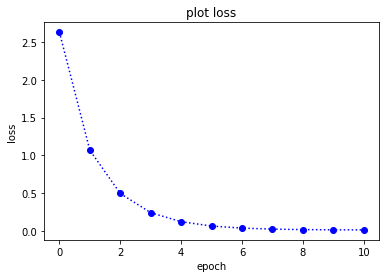

In [ ]:
# SGD
batch_size = 10 # 배치 크기
lr = 0.1 # 학습률
MaxEpochs = 10 # 반복 횟수

paths = []
batch_loss = []
loss_epoch = []
w0 = np.array([4.0, -1.0]) # 1) 초깃값
search_direction = np.zeros_like(w0)

print(search_direction)

# 2) 데이터 셔플링
np.random.seed(320)
idx = np.arange(len(x_train))
np.random.shuffle(idx)
print(idx)
shuffled_x_train = x_train[idx]
shuffled_y_train = y_train[idx]
print(shuffled_x_train)
print()
print(shuffled_y_train)
print()

# 알고리즘
for epoch in range(MaxEpochs+1): # 5) MaxEpochs번 반복

    ## DIY(4)3) 미니 배치 생성
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))

        grad = loss_grad(w0, x_batch, y_batch) # 4)-1 미니 배치에서 그래디언트 계산
        search_direction = -grad # 4)-2 탐색 방향 설정
        lr = lr # 4)-3 학습률 설정
        # 4)-4 파라미터 업데이트
        dw = lr * search_direction
        w0 = w0 + dw
    #print('{:02d}\t{}\t{:5.4f}'.format(epoch, w0, loss(w0, x_train, y_train)))
    loss_epoch.append(loss(w0, x_train, y_train))
    print('{:02d}\t{}\t{:e}'.format(epoch, w0, loss(w0, x_train, y_train)))

#개별 추가 작성
plt.figure()
plt.plot(loss_epoch, 'bo:')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('plot loss')
plt.show()

# **SGD: Part-B**

### SGD 알고리즘
- 시각화(1): 손실함숫값이 최소로 접근해 가는 과정

In [ ]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (16./3, 3)

def contour_with_path(l, x, y, paths, norm=LogNorm(), level=np.logspace(0, 5, 35), minima=None):
    paths = np.array(paths).T
    fig, ax = plt.subplots(figsize=(7, 4))

    ax.contour(x, y, l, levels=level, norm=norm, cmap=plt.cm.jet)
    ax.quiver(paths[0,:-1], paths[1,:-1], paths[0,1:]-paths[0,:-1], paths[1,1:]-paths[1,:-1], \
              scale_units='xy', angles='xy', scale=1, color='k')

    if minima is not None:
        ax.plot(*minima, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.show()


In [ ]:
W0 = np.linspace(-5, 7, 101)
W1 = np.linspace(-2, 5, 101)
W0, W1 = np.meshgrid(W0,W1)
LOSSW = W0 * 0
for i in range(W0.shape[0]):
    for j in range(W0.shape[1]):
        wij = np.array([W0[i,j], W1[i,j]])
        LOSSW[i,j] = loss(wij, x_train, y_train)

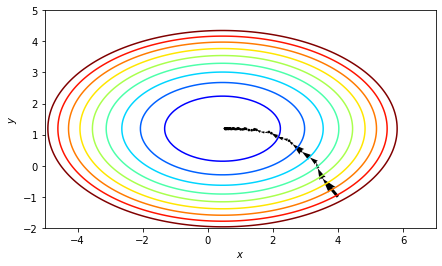

In [ ]:
contour_with_path(LOSSW, W0, W1, paths, norm=None, level=np.linspace(0, 10, 10))
#GD 사용시 완만한 곡선이 나오지만 SGD는 높낮이 차이를 보이는 선으로 표시됨

### SGD 알고리즘
- 시각화(2): 매 에포크 을 통해 찾아진 가중치(weights; 선형회귀곡선의 기울기/절편)의 근삿값에 대한 '손실함숫값'

55

[1.45552202e+01 5.05331001e+00 1.85214858e+00 3.73758473e+00
 4.23118536e+00 4.33686742e+00 1.46077218e+00 5.29802834e-01
 1.48400018e+00 1.76590618e+00 1.67414022e+00 6.18230645e-01
 2.61720186e-01 6.95553764e-01 8.47408803e-01 7.25252022e-01
 2.99988872e-01 1.42888229e-01 3.36645385e-01 4.29390440e-01
 3.27894415e-01 1.54200128e-01 8.02576463e-02 1.64214608e-01
 2.26123904e-01 1.50745068e-01 8.40469980e-02 4.80769630e-02
 8.13978533e-02 1.24613360e-01 7.05047171e-02 4.98333636e-02
 3.20489103e-02 4.20376390e-02 7.29524525e-02 3.44875373e-02
 3.30143617e-02 2.42086172e-02 2.35905779e-02 4.61300912e-02
 1.88020398e-02 2.46708455e-02 2.04099002e-02 1.51080862e-02
 3.18711598e-02 1.23769694e-02 2.04823546e-02 1.85794766e-02
 1.13184136e-02 2.40784919e-02 1.00668673e-02 1.83469680e-02
 1.77010805e-02 9.70473903e-03 1.96857955e-02]


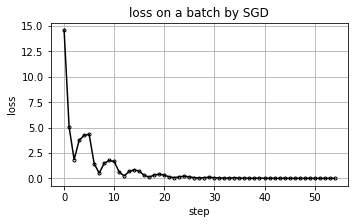

In [ ]:
print(len(batch_loss))
print()

print(np.array(batch_loss).T)

plt.plot(batch_loss, '.-k', markerfacecolor='none')
plt.grid()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('loss on a batch by SGD')
plt.show()

### Revisit
- 시각화: visualize_l2


---


- 시각화를 위해 사용할 모듈
  - "from matplotlib.patches import Rectangle"
    - 웹자료(1): [Matplotlib: Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html)
    - 웹자료(2): [Matplotlib: box for error bar](https://matplotlib.org/stable/gallery/statistics/errorbars_and_boxes.html#sphx-glr-gallery-statistics-errorbars-and-boxes-py)

In [ ]:
"""
def visualize_l2(w, b, x_train, y_train, loss):
    from matplotlib.patches import Rectangle
    loss_name = loss.__name__
    plt.plot(x_train, y_train, '.k', markerfacecolor='none') # train date 그리기
    plt.plot(x_train, w * x_train + b, '--b') # 예측된 선형회귀곡선 그리기
    currentAxis = plt.gca()
    for xx,yy in zip(x_train, y_train):
        currentAxis.add_patch(Rectangle((xx, yy),                            ## corner point
                                        w * xx + b - yy, w * xx + b - yy,    ## width, height
                              alpha=0.1, facecolor='gray', edgecolor='k'))
    plt.grid()
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("a={:1.2f}, b={:1.2f}({}={:5.4f})".format(w, b, loss_name, loss(w,b)))

visualize_l2(-4, -1, x_train, y_train, loss)
plt.show()
"""

'\ndef visualize_l2(w, b, x_train, y_train, loss):\n    from matplotlib.patches import Rectangle\n    loss_name = loss.__name__\n    plt.plot(x_train, y_train, \'.k\', markerfacecolor=\'none\') # train date 그리기\n    plt.plot(x_train, w * x_train + b, \'--b\') # 예측된 선형회귀곡선 그리기\n    currentAxis = plt.gca()\n    for xx,yy in zip(x_train, y_train):\n        currentAxis.add_patch(Rectangle((xx, yy),                            ## corner point\n                                        w * xx + b - yy, w * xx + b - yy,    ## width, height\n                              alpha=0.1, facecolor=\'gray\', edgecolor=\'k\'))\n    plt.grid()\n    plt.axis(\'equal\')\n    plt.xlabel(\'x\')\n    plt.ylabel(\'y\')\n    plt.title("a={:1.2f}, b={:1.2f}({}={:5.4f})".format(w, b, loss_name, loss(w,b)))\n\nvisualize_l2(-4, -1, x_train, y_train, loss)\nplt.show()\n'